In [ ]:
# #COMPLETED
# A. Data Collection
# B. Text Preprocessing
# C. EDA
# D. Feature Engineering
# D3. Sentiment Preprocessing
#  D3a. Embedded Text using SentenceTransformer
# #OUTPUT DATASET
# 1. tweets_embedded_df.parquet
# 2. stock_price_df.parquet
# #-----------------------------------------------

# #CONTINUE
#load tweets_embedded_df.parquet vs. stock_price_df.parquet
# D3. Sentiment Preprocessing
    # - Load pre-trained sentiment models (BERTweet, DistilBERT-SST2).
    # - Score tweets using each model and store the sentiment scores in the dataframe.
    # - Loughran-McDonald Lexicon scoring for additional sentiment analysis.
    # => save tweets_sentiments_df.parquet

    # LOAD tweets_sentiments_df.parquet TO RUN FAISS
    # - FAISS IndexIVFFlat for vector store and neighbor smoothing of sentiment scores.
    # => save tweets_sent_smooth_df.parquet

# D4. Merge Data: Combine sentiment-enriched tweets with stock data.
# D5. Volume Z-Score: Calculate and add rolling 7-day z-score of volume.
# D6. Sentiment × Volume: Create and add interaction term.
# E. Time Split: Split data into training, validation, and testing sets.
# F. Feature Engineering: Explore and add other stock-related features.
# G. Modeling: Train and tune machine learning models.
# H. Evaluation: Evaluate model performance on the testing set.
#OUTPUT
# tweets_sentiments_df.parquet
# tweets_sent_smooth_df.parquet (after FAISS, use this one to run model)

# Load Processed Dataset

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch

In [ ]:
import os
if os.path.exists('./tweets_embedded_df.parquet'):
  print('File exists')
else:
  print('File not found')

File not found


In [ ]:
tweets_df = pd.read_parquet('./tweets_embedded_df.parquet')

In [2]:
stock_df = pd.read_parquet('./stock_prices.parquet')

In [ ]:
# tweets_df.head()

In [ ]:
print(tweets_df['emb_mpnet_basev2'].shape) #1D array (or series) with 379331 elements
#each element in col directly stores a single tweet embedding/vector of nums => already stack up tgt

(379331,)


# Feature Engineering

## Sentiment Preprocessing

### Sentiment: BERTweet

In [ ]:
!pip install huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 44.2 MB/s eta 0:00:00


In [ ]:
tweets_sent_df = tweets_df.copy()
tweets= tweets_sent_df["cleaned_text"].tolist()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tok_bt = AutoTokenizer.from_pretrained(
    "finiteautomata/bertweet-base-sentiment-analysis",normalization=True)
mdl_bt = AutoModelForSequenceClassification.from_pretrained(
    "finiteautomata/bertweet-base-sentiment-analysis").to("cuda").eval()

def score_bertweet(texts, bs=512):
    out = np.zeros(len(texts), dtype=float)
    for i in tqdm(range(0, len(texts), bs),desc="Scoring BERTweet",unit="batch"):
        batch=texts[i : i + bs]
        enc=tok_bt(
            batch,
            padding=True,
            truncation=True,
            max_length=96,
            return_tensors="pt"
        ).to("cuda")
        with torch.inference_mode():
            logits = mdl_bt(**enc).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        out[i:i+bs]=probs[:,2]-probs[:,0]
    return out
#Run with progress bar
tweets_sent_df["bertweet_score"] = score_bertweet(tweets)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Scoring BERTweet:   0%|          | 0/741 [00:00<?, ?batch/s]

### Sentiment: DistilBERT-SST2

In [ ]:
tok_ds = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english")
mdl_ds = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english").to("cuda").eval()

def score_distilbert(texts, bs=256):
    out = np.zeros(len(texts), dtype=float)
    for i in tqdm(range(0, len(texts), bs),
                  desc="Scoring DistilBERT",
                  unit="batch"):
        batch = texts[i : i + bs]
        enc = tok_ds(
            batch,
            padding=True,
            truncation=True,
            max_length=96,
            return_tensors="pt"
        ).to("cuda")
        with torch.inference_mode():
            logits = mdl_ds(**enc).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        out[i:i+bs]=probs[:,1]*2-1
    return out
tweets_sent_df["distilbert_score"] = score_distilbert(tweets)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Scoring DistilBERT:   0%|          | 0/1482 [00:00<?, ?batch/s]

### Sentiment: Loughran-McDonald Lexicon

In [ ]:
lm = pd.read_csv("/content/Loughran-McDonald_MasterDictionary_1993-2024.csv")

pos = set(lm.loc[lm["Positive"] > 0, "Word"].str.upper())
neg = set(lm.loc[lm["Negative"] > 0, "Word"].str.upper())
#lexicon scoring function
def lm_score(txt: str) -> float:
    toks = txt.split()
    if not toks:
        return 0.0
    up_count = sum(token.upper() in pos for token in toks)
    down_count = sum(token.upper() in neg for token in toks)
    return (up_count - down_count) / len(toks)
tqdm.pandas(desc="Lexicon scoring")
tweets_sent_df["lm_score"] = tweets_sent_df["cleaned_text"].progress_apply(lm_score)

Lexicon scoring:   0%|          | 0/379331 [00:00<?, ?it/s]

In [ ]:
tweets_sent_df.head()

,datetime,content,date,cleaned_text,emb_mpnet_basev2,bertweet_score,distilbert_score,lm_score
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...,2022-07-11,important since [ ticker ] may start cracking ...,"[-0.035491943359375, -0.0006866455078125, -0.0...",-0.362882,-0.981977,0.000000
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...,2022-07-11,[ ticker ] technicals look good ( broke above ...,"[-0.013519287109375, 0.007720947265625, -0.020...",0.890500,-0.256132,0.017544
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...,2022-07-11,exactly . there may never be a way to weigh [ ...,"[-0.048553466796875, 0.032440185546875, 0.0014...",-0.608964,-0.998648,0.000000
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...,2022-07-11,and that 's how you negotiate an exclusivity d...,"[-0.01168060302734375, 0.01544952392578125, -0...",-0.020917,0.987530,0.033333
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...,2022-07-11,trending stocks on : source : finapse.live 1 ....,"[-0.052886962890625, -0.00390625, -0.036987304...",0.035807,-0.982498,0.000000


### Vector store: FAISS IndexIVFFlat vector index for top-k retrieval => FAISS neighbor Smoothing for sent scores
- FAISS (Facebook AI Similarity Search) is a library that allows for efficient similarity search and clustering of dense vectors. IndexIVFFlat is a type of index in FAISS that provides a good balance between speed and accuracy for large datasets. It's particularly suitable for top-k retrieval, where you want to find the k most similar vectors to a query vector

- Fast cosine-similarity search so the RAG retriever can pull the k most semantically similar tweets to a daily query.

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 77.8 MB/s eta 0:00:00


In [ ]:
import faiss

# Stack vectors if 'embedded_text' has nested lists/arrays
# if embeddings are nested (separate stacks), np.vstack combines into a single 2D np array
vecs = np.vstack(tweets_sent_df['emb_mpnet_basev2'].to_numpy()).astype('float32')
vecs.shape

(379331, 768)

In [ ]:
#create index
d=vecs.shape[1]
nlist = 100  #num of clusters for IVF (inverted file index)
quantizer = faiss.IndexFlatL2(d)#quantizer for IVF
index = faiss.IndexIVFFlat(quantizer, d, nlist)
#train index, cluster data and prep inde for searching
index.train(vecs)
#add vectors, populate index with actual vector
index.add(vecs)


In [ ]:
# # #search
# # k=10 #num of nearest neighbors to retrieve
# # D, I =index.search(vecs, k)
# # print(I) #indices of the k-most similar tweets for each vectors

# def retrieve_topk(query_vec: np.ndarray, k: int = 500):
#     D, I = index.search(query_vec.reshape(1, -1), k)
#     return I[0]

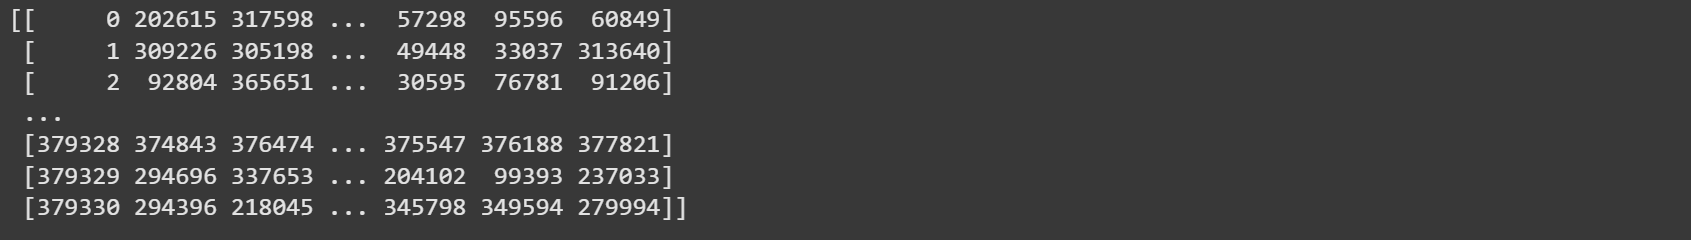

- Each row in I corresponds to a vector in your original dataset (vecs).
- Each column in I represents the index of a nearest neighbor. The first column (index 0) is the index of the vector itself (as it's the closest to itself), followed by the indices of the next closest vectors

=>  Each row in I gives the indices of the tweets that are most similar to the tweet represented by that row's index

- The first row [0 202615 317598 ... 57298 95596 60849] indicates that the tweet at index 0 is most similar to itself (index 0), then the tweet at index 202615, then the tweet at index 317598, and so on

In [ ]:
# similar_tweet_indices = I[0]
# similar_tweets = tweets_df.iloc[similar_tweet_indices]['cleaned_text']
# print(similar_tweets)

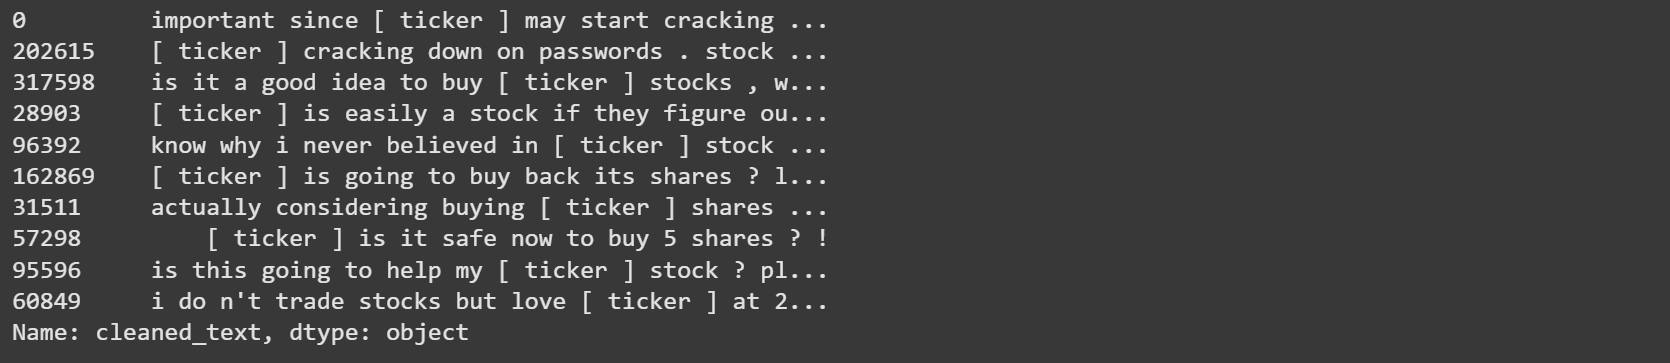

In [ ]:
tweets_sent_df.to_parquet('./tweets_sentiments_df.parquet', index=False)

In [ ]:
#LOAD tweets_sentiments_df.parquet TO RUN FAISS
tweets_sent_df=pd.read_parquet("/content/tweets_sentiments_df.parquet")

In [ ]:
#Retrieve neighbors
k = 500
_, I = index.search(vecs, k)
#Smooth sentiment scores
# wont smooth 'lm_score'
sentiment_cols = ['bertweet_score','distilbert_score']
for col in sentiment_cols:
    scores = tweets_sent_df[col].to_numpy()
    tweets_sent_df[f"{col}_smooth"] = scores[I].mean(axis=1)

In [ ]:
tweets_sent_df.head()

,datetime,content,date,cleaned_text,emb_mpnet_basev2,bertweet_score,distilbert_score,lm_score,bertweet_score_smooth,distilbert_score_smooth
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...,2022-07-11,important since [ ticker ] may start cracking ...,"[-0.035491943359375, -0.0006866455078125, -0.0...",-0.362882,-0.981977,0.000000,0.013832,-0.453581
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...,2022-07-11,[ ticker ] technicals look good ( broke above ...,"[-0.013519287109375, 0.007720947265625, -0.020...",0.890500,-0.256132,0.017544,0.281678,-0.236992
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...,2022-07-11,exactly . there may never be a way to weigh [ ...,"[-0.048553466796875, 0.032440185546875, 0.0014...",-0.608964,-0.998648,0.000000,-0.081699,-0.534219
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...,2022-07-11,and that 's how you negotiate an exclusivity d...,"[-0.01168060302734375, 0.01544952392578125, -0...",-0.020917,0.987530,0.033333,0.020399,-0.456231
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...,2022-07-11,trending stocks on : source : finapse.live 1 ....,"[-0.052886962890625, -0.00390625, -0.036987304...",0.035807,-0.982498,0.000000,0.035807,-0.982498


 Lexicon scores are already lightweight counts—neighborhood smoothing there generally adds little, and is costly to compute.

=== Summary Statistics ===
                            count      mean       std       min       25%  \
bertweet_score           379331.0  0.087708  0.477209 -0.980639 -0.012435   
bertweet_score_smooth    379331.0  0.094660  0.251549 -0.829883  0.002819   
distilbert_score         379331.0 -0.619855  0.711474 -0.999652 -0.995335   
distilbert_score_smooth  379331.0 -0.606502  0.304204 -0.998758 -0.826529   

                              50%       75%       max  
bertweet_score           0.026212  0.281460  0.991451  
bertweet_score_smooth    0.090222  0.232814  0.950645  
distilbert_score        -0.985764 -0.818023  0.999779  
distilbert_score_smooth -0.667369 -0.458106  0.878859  

Correlation (BERTweet raw vs. smoothed): 0.613
Correlation (DistilBERT raw vs. smoothed): 0.454


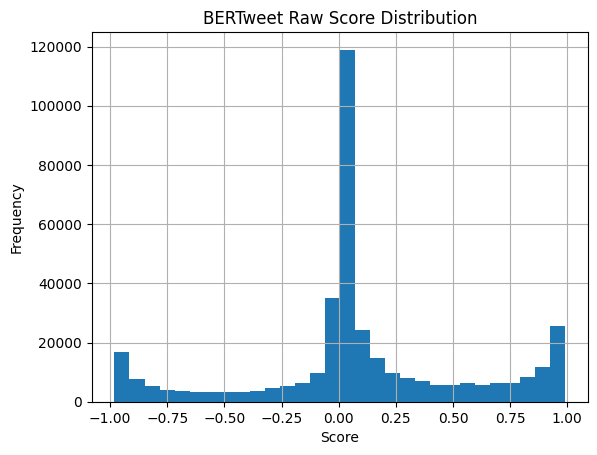

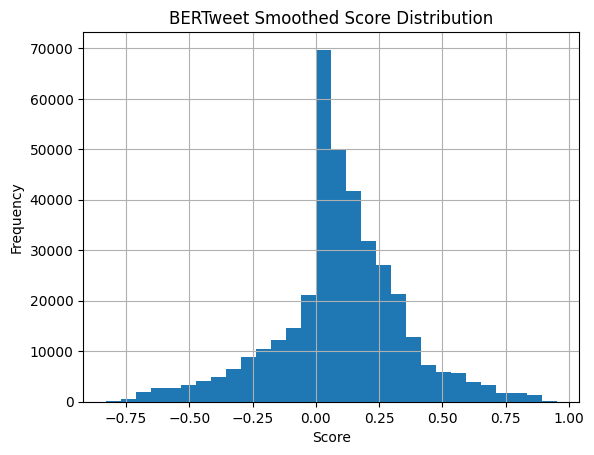

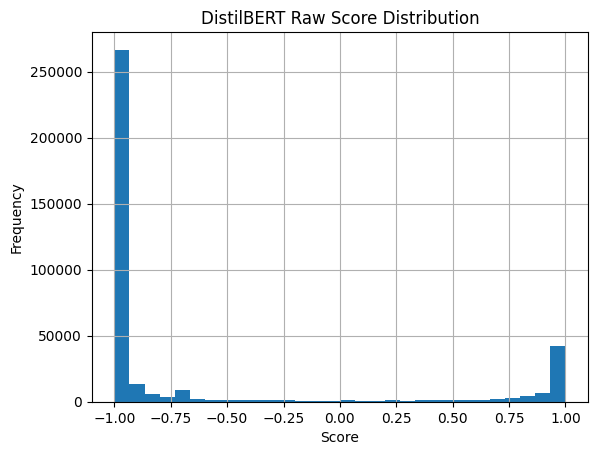

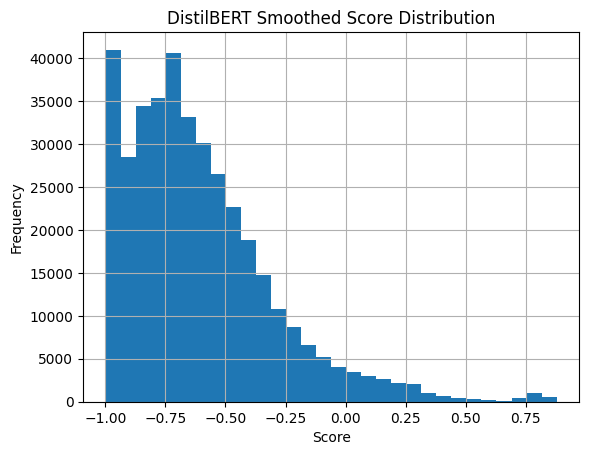

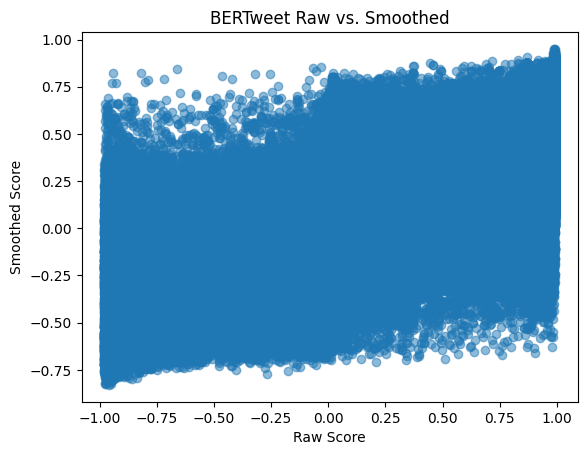

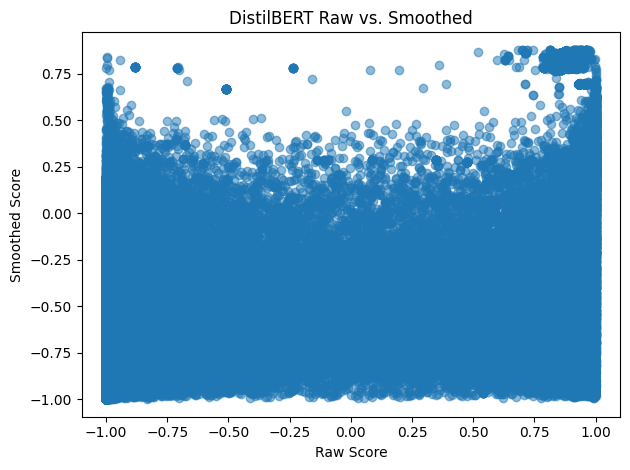

In [ ]:

# 2. Summary statistics for raw vs. smoothed scores
stats = tweets_sent_df[['bertweet_score', 'bertweet_score_smooth',
            'distilbert_score', 'distilbert_score_smooth']].describe().T
print("=== Summary Statistics ===")
print(stats)

# 3. Pearson correlations between raw and smoothed
corr_bt = tweets_sent_df['bertweet_score'].corr(tweets_sent_df['bertweet_score_smooth'])
corr_db = tweets_sent_df['distilbert_score'].corr(tweets_sent_df['distilbert_score_smooth'])
print(f"\nCorrelation (BERTweet raw vs. smoothed): {corr_bt:.3f}")
print(f"Correlation (DistilBERT raw vs. smoothed): {corr_db:.3f}")

# 4. Plot histograms
plt.figure()
tweets_sent_df['bertweet_score'].hist(bins=30)
plt.title('BERTweet Raw Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.figure()
tweets_sent_df['bertweet_score_smooth'].hist(bins=30)
plt.title('BERTweet Smoothed Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.figure()
tweets_sent_df['distilbert_score'].hist(bins=30)
plt.title('DistilBERT Raw Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.figure()
tweets_sent_df['distilbert_score_smooth'].hist(bins=30)
plt.title('DistilBERT Smoothed Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

# 5. Scatter plots of raw vs. smoothed
plt.figure()
plt.scatter(tweets_sent_df['bertweet_score'], tweets_sent_df['bertweet_score_smooth'], alpha=0.5)
plt.title('BERTweet Raw vs. Smoothed')
plt.xlabel('Raw Score')
plt.ylabel('Smoothed Score')

plt.figure()
plt.scatter(tweets_sent_df['distilbert_score'], tweets_sent_df['distilbert_score_smooth'], alpha=0.5)
plt.title('DistilBERT Raw vs. Smoothed')
plt.xlabel('Raw Score')
plt.ylabel('Smoothed Score')

plt.tight_layout()
plt.show()

 Smoothing is doing its job: you’ve removed most of the “spiky” noise without obliterating genuine sentiment differences.

BERTweet vs. DistilBERT: smoothing had a larger net effect on DistilBERT—if you trust that model less, you might prefer its smoothed version more.

In [ ]:
tweets_sent_df.to_parquet('./tweets_sent_smooth_df.parquet', index=False)

### Daily Aggregates: Day-level sentiment aggregation via retrieval
- use a look-back window (7 calendar days) that ends one day before the trading session i'm predicting

=> guarantees to never leak same-day information into the label and gives the model a “memory” of sentiment momentum

=> so when i train a model to predict whether price(T) will go up tomorrow, it only sees sentiment information that was actually available as of yesterday’s close

In [3]:
tweets_sent_df=pd.read_parquet("/content/tweets_sent_smooth_df.parquet")

In [4]:
 tweets_sent_df['tweet_count'] = 1  # Initialize with 1 for each tweet
daily_sent_df = tweets_sent_df.groupby("date").agg({
    "bertweet_score":  "mean",
    "bertweet_score_smooth": "mean",
    "distilbert_score":"mean",
    "distilbert_score_smooth":"mean",
    "lm_score":"mean",
    "tweet_count":"sum"  # Now you can sum to get tweet count
})
daily_sent_df.rename(columns={"tweet_count":"tweetVol"}, inplace=True)

### Compute rolling 7-day z-score of volume
- Balance spikes thru out the year

In [5]:
daily_sent_df['z_vol_7d'] = (
    daily_sent_df['tweetVol']
    .rolling(window=7, min_periods=1)
    .apply(lambda x: (x.iloc[-1] - x.mean()) / x.std() if x.std() else 0.0)
)

### Create 1‐day and 7‐day lags

In [6]:
#Create 1‐day and 7‐day lags
base_cols = [
    'tweetVol',
    'bertweet_score',
    "bertweet_score_smooth",
    'distilbert_score',
    "distilbert_score_smooth",
    'lm_score',
    'z_vol_7d'
]
lags = {'prev1': 1, 'prev7': 7}

for col in base_cols:
    for suf, lag in lags.items():
        daily_sent_df[f"{col}_{suf}"] = daily_sent_df[col].shift(lag)

In [7]:
lag_cols = [f"{col}_{suf}" for col in base_cols for suf in lags]
daily_sent_df.dropna(subset=lag_cols, inplace=True)
daily_sent_df.head()

,bertweet_score,bertweet_score_smooth,distilbert_score,distilbert_score_smooth,lm_score,tweetVol,z_vol_7d,tweetVol_prev1,tweetVol_prev7,bertweet_score_prev1,...,bertweet_score_smooth_prev1,bertweet_score_smooth_prev7,distilbert_score_prev1,distilbert_score_prev7,distilbert_score_smooth_prev1,distilbert_score_smooth_prev7,lm_score_prev1,lm_score_prev7,z_vol_7d_prev1,z_vol_7d_prev7
date,,,,,,,,,,,,,,,,,,,,,
2020-01-13,0.167780,0.149444,-0.512321,-0.577963,-0.000051,632,0.896746,294.0,339.0,0.094329,...,0.119168,0.139035,-0.680523,-0.581514,-0.611905,-0.603792,-0.001801,0.000076,-0.817063,0.707107
2020-01-14,0.160484,0.150682,-0.578014,-0.593593,0.000428,421,-0.413015,632.0,309.0,0.167780,...,0.149444,0.087925,-0.512321,-0.606658,-0.577963,-0.622866,-0.000051,-0.003780,0.896746,0.444396
2020-01-15,0.115418,0.105331,-0.642699,-0.628737,-0.000783,318,-0.916859,421.0,776.0,0.160484,...,0.150682,0.131425,-0.578014,-0.578558,-0.593593,-0.587512,0.000428,0.000503,-0.413015,1.407628
2020-01-16,0.109753,0.109174,-0.534526,-0.614698,0.000701,380,-0.322977,318.0,422.0,0.115418,...,0.105331,0.134357,-0.642699,-0.646451,-0.628737,-0.612101,-0.000783,-0.000756,-0.916859,0.117500
2020-01-17,0.148621,0.112966,-0.569156,-0.594472,0.000710,446,0.325398,380.0,501.0,0.109753,...,0.109174,0.115492,-0.534526,-0.493936,-0.614698,-0.544303,0.000701,-0.001461,-0.322977,0.407770


### Ensemble scores

In [8]:
ensemble_t1 = [
    "bertweet_score_smooth_prev1",
    "distilbert_score_smooth_prev1",
    "lm_score_prev1"
]
ensemble_t7 = [
    "bertweet_score_smooth_prev7",
    "distilbert_score_smooth_prev7",
    "lm_score_prev7"
]

# 2) Compute the two continuous ensemble scores
daily_sent_df["ensemble_score_t1"] = daily_sent_df[ensemble_t1].mean(axis=1)
daily_sent_df["ensemble_score_t7"] = daily_sent_df[ensemble_t7].mean(axis=1)

In [9]:
daily_sent_df.head()

,bertweet_score,bertweet_score_smooth,distilbert_score,distilbert_score_smooth,lm_score,tweetVol,z_vol_7d,tweetVol_prev1,tweetVol_prev7,bertweet_score_prev1,...,distilbert_score_prev1,distilbert_score_prev7,distilbert_score_smooth_prev1,distilbert_score_smooth_prev7,lm_score_prev1,lm_score_prev7,z_vol_7d_prev1,z_vol_7d_prev7,ensemble_score_t1,ensemble_score_t7
date,,,,,,,,,,,,,,,,,,,,,
2020-01-13,0.167780,0.149444,-0.512321,-0.577963,-0.000051,632,0.896746,294.0,339.0,0.094329,...,-0.680523,-0.581514,-0.611905,-0.603792,-0.001801,0.000076,-0.817063,0.707107,-0.164846,-0.154894
2020-01-14,0.160484,0.150682,-0.578014,-0.593593,0.000428,421,-0.413015,632.0,309.0,0.167780,...,-0.512321,-0.606658,-0.577963,-0.622866,-0.000051,-0.003780,0.896746,0.444396,-0.142856,-0.179574
2020-01-15,0.115418,0.105331,-0.642699,-0.628737,-0.000783,318,-0.916859,421.0,776.0,0.160484,...,-0.578014,-0.578558,-0.593593,-0.587512,0.000428,0.000503,-0.413015,1.407628,-0.147495,-0.151861
2020-01-16,0.109753,0.109174,-0.534526,-0.614698,0.000701,380,-0.322977,318.0,422.0,0.115418,...,-0.642699,-0.646451,-0.628737,-0.612101,-0.000783,-0.000756,-0.916859,0.117500,-0.174730,-0.159500
2020-01-17,0.148621,0.112966,-0.569156,-0.594472,0.000710,446,0.325398,380.0,501.0,0.109753,...,-0.534526,-0.493936,-0.614698,-0.544303,0.000701,-0.001461,-0.322977,0.407770,-0.168274,-0.143424



### Adding a “sentiment × volume” interaction

A single positive tweet on a quiet day shouldn’t carry the same weight as thousands of positive tweets ahead of earnings.

The product term lets a linear model approximate that non-linear intuition—high magnitude only when both sentiment and volume deviate markedly from their norms.


In [10]:
daily_sent_df['bertweet_smooth_x_zvol_prev1'] = daily_sent_df['bertweet_score_smooth_prev1'] * daily_sent_df['z_vol_7d_prev1']
daily_sent_df['bertweet_smooth_x_zvol_prev7'] = daily_sent_df['bertweet_score_smooth_prev7'] * daily_sent_df['z_vol_7d_prev7']


# Merge stock_df with tweets_sent_df

In [11]:
master_df=pd.merge(stock_df,daily_sent_df,on='date')
master_df.head()

,date,close,high,low,open,volume,PrevReturn,next_open,next_close,label_open_up,...,distilbert_score_smooth_prev1,distilbert_score_smooth_prev7,lm_score_prev1,lm_score_prev7,z_vol_7d_prev1,z_vol_7d_prev7,ensemble_score_t1,ensemble_score_t7,bertweet_smooth_x_zvol_prev1,bertweet_smooth_x_zvol_prev7
0,2020-01-13,338.920013,340.850006,331.510010,331.799988,6290000,0.029996,344.399994,338.690002,1,...,-0.611905,-0.603792,-0.001801,0.000076,-0.817063,0.707107,-0.164846,-0.154894,-0.097368,0.098313
1,2020-01-14,338.690002,345.380005,335.519989,344.399994,7199400,-0.000679,338.679993,339.070007,0,...,-0.577963,-0.622866,-0.000051,-0.003780,0.896746,0.444396,-0.142856,-0.179574,0.134014,0.039074
2,2020-01-15,339.070007,343.170013,336.600006,338.679993,5158000,0.001122,343.500000,338.619995,1,...,-0.593593,-0.587512,0.000428,0.000503,-0.413015,1.407628,-0.147495,-0.151861,-0.062234,0.184997
3,2020-01-16,338.619995,343.559998,335.850006,343.500000,5016000,-0.001327,341.000000,339.670013,1,...,-0.628737,-0.612101,-0.000783,-0.000756,-0.916859,0.117500,-0.174730,-0.159500,-0.096573,0.015787
4,2020-01-17,339.670013,341.570007,337.380005,341.000000,6066500,0.003101,340.000000,338.109985,1,...,-0.614698,-0.544303,0.000701,-0.001461,-0.322977,0.407770,-0.168274,-0.143424,-0.035261,0.047094


In [12]:
print(master_df.columns)

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'PrevReturn',
       'next_open', 'next_close', 'label_open_up', 'label_close_up',
       'earnings_window', 'bertweet_score', 'bertweet_score_smooth',
       'distilbert_score', 'distilbert_score_smooth', 'lm_score', 'tweetVol',
       'z_vol_7d', 'tweetVol_prev1', 'tweetVol_prev7', 'bertweet_score_prev1',
       'bertweet_score_prev7', 'bertweet_score_smooth_prev1',
       'bertweet_score_smooth_prev7', 'distilbert_score_prev1',
       'distilbert_score_prev7', 'distilbert_score_smooth_prev1',
       'distilbert_score_smooth_prev7', 'lm_score_prev1', 'lm_score_prev7',
       'z_vol_7d_prev1', 'z_vol_7d_prev7', 'ensemble_score_t1',
       'ensemble_score_t7', 'bertweet_smooth_x_zvol_prev1',
       'bertweet_smooth_x_zvol_prev7'],
      dtype='object')


In [13]:
master_df.shape

(626, 37)

In [14]:
TARGET = 'label_close_up'    # or 'label_open_up'

FEATURES=[
       'PrevReturn','earnings_window',
        'tweetVol_prev1', 'tweetVol_prev7',
       'bertweet_score_prev1','bertweet_score_prev7', 'bertweet_score_smooth_prev1',
       'bertweet_score_smooth_prev7', 'distilbert_score_prev1',
       'distilbert_score_prev7', 'distilbert_score_smooth_prev1',
       'distilbert_score_smooth_prev7', 'lm_score_prev1', 'lm_score_prev7',
       'z_vol_7d_prev1', 'z_vol_7d_prev7', 'ensemble_score_t1',
       'ensemble_score_t7', 'bertweet_smooth_x_zvol_prev1',
       'bertweet_smooth_x_zvol_prev7'
]

# Time_series Split

In [15]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

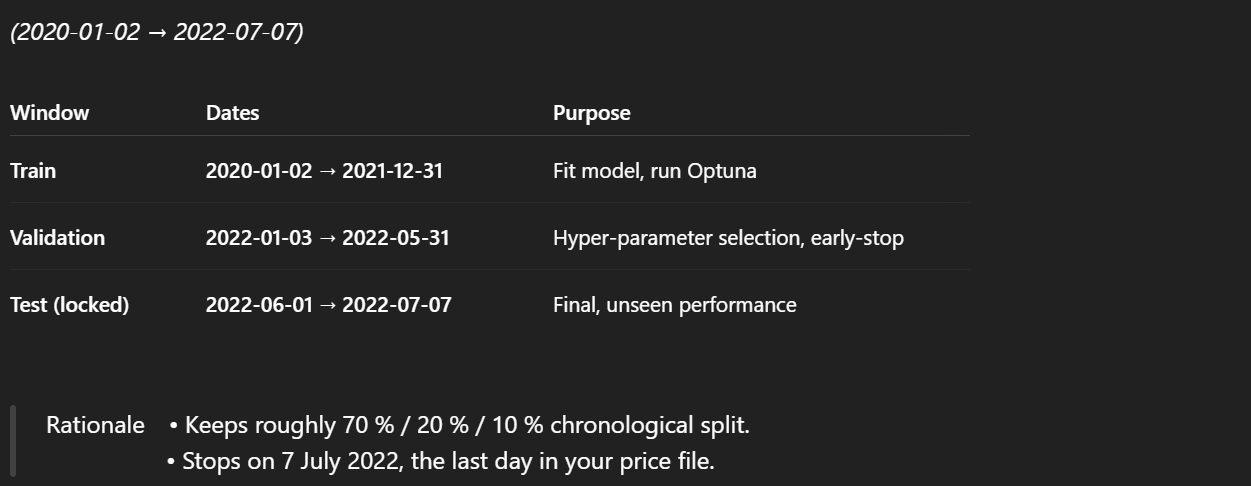

In [16]:
master_df['date'] = pd.to_datetime(master_df['date'])
master_df = master_df.set_index('date')

In [17]:
master_df = master_df.sort_index()
train_df = master_df.loc["2020-01-02":"2021-12-31"]
val_df  = master_df.loc["2022-01-03":"2022-05-31"]
test_df  = master_df.loc["2022-06-01":"2022-07-07"]

print("Label balance:")
for name, split in [("train",train_df),("val",val_df),("test",test_df)]:
    print(name, split["label_close_up"].value_counts(normalize=True).to_dict())

tscv = TimeSeriesSplit(n_splits=5)

Label balance:
train {1: 0.5281124497991968, 0: 0.4718875502008032}
val {0: 0.5922330097087378, 1: 0.4077669902912621}
test {0: 0.56, 1: 0.44}


# Feature Importance (Permutation on VAL)
- fit a quick XGB for importance

In [18]:
import xgboost as xgb
from sklearn.inspection import permutation_importance

xgb_quick = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_quick.fit(train_df[FEATURES].values, train_df[TARGET].values)
imp = permutation_importance(
    xgb_quick, val_df[FEATURES].values, val_df[TARGET].values,
    n_repeats=8, scoring="accuracy", n_jobs=-1)
print("Permutation importances:")
for i in imp.importances_mean.argsort()[::-1]:
    print(f"{FEATURES[i]:20s} : {imp.importances_mean[i]:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:21:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Permutation importances:
z_vol_7d_prev7       : 0.0024
earnings_window      : 0.0000
tweetVol_prev7       : -0.0024
bertweet_score_smooth_prev1 : -0.0049
bertweet_score_smooth_prev7 : -0.0073
bertweet_smooth_x_zvol_prev7 : -0.0073
ensemble_score_t7    : -0.0073
PrevReturn           : -0.0109
ensemble_score_t1    : -0.0121
bertweet_score_prev7 : -0.0158
distilbert_score_prev7 : -0.0194
distilbert_score_smooth_prev7 : -0.0243
bertweet_smooth_x_zvol_prev1 : -0.0279
bertweet_score_prev1 : -0.0279
lm_score_prev1       : -0.0291
lm_score_prev7       : -0.0376
distilbert_score_smooth_prev1 : -0.0425
distilbert_score_prev1 : -0.0425
tweetVol_prev1       : -0.0522
z_vol_7d_prev1       : -0.0534


Global feature importance (bar)


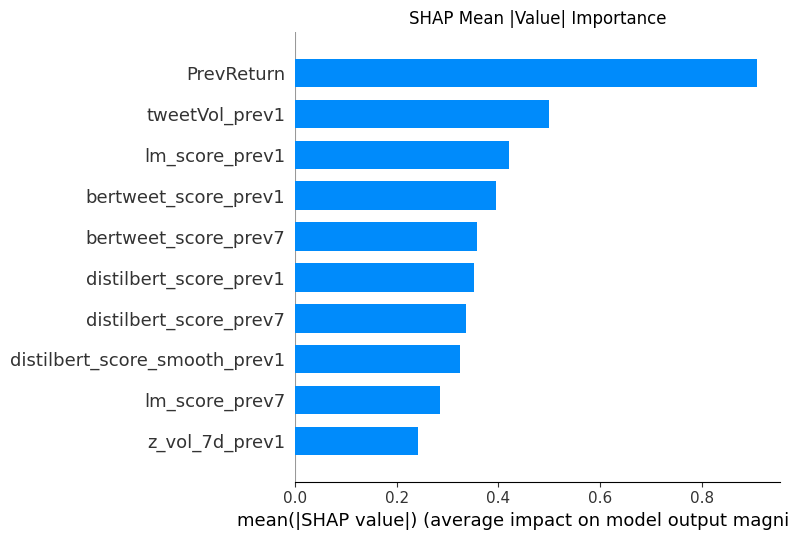

SHAP summary (violin)


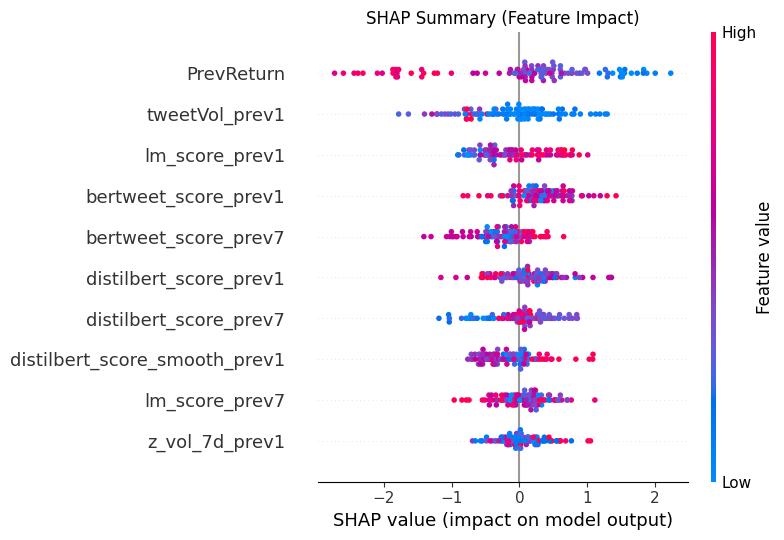

In [19]:
import shap

explainer = shap.TreeExplainer(xgb_quick)
shap_values = explainer.shap_values(val_df[FEATURES])

#Global feature importance (bar)
print('Global feature importance (bar)')
shap.summary_plot(
    shap_values,
    val_df[FEATURES],
    plot_type="bar",
    max_display=10,
    show=False
)
plt.title("SHAP Mean |Value| Importance")
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


#SHAP summary (violin)
print('SHAP summary (violin)')
shap.summary_plot(
    shap_values,
    val_df[FEATURES],
    max_display=10,
    show=False
)
plt.title("SHAP Summary (Feature Impact)")
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [20]:
finalFEATURES=[
    "PrevReturn",
    "tweetVol_prev1",
    "lm_score_prev1",
    "bertweet_score_prev1",
    "bertweet_score_prev7",
    "bertweet_score_smooth_prev7",
    'ensemble_score_t1',
    'earnings_window',
]

# Modelling and Hypertune with Loss Curves
- Logistic Regression
- Shallow NN
- XGBoost
-LSTM

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [22]:
#Logistic Regression
lr = LogisticRegression(class_weight="balanced", max_iter=500)
gs_lr = GridSearchCV(
    lr, {"C":[0.01,0.1,1,10]},
    cv=tscv, scoring="accuracy", n_jobs=-1, verbose=1
)
gs_lr.fit(train_df[finalFEATURES], train_df[TARGET])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=500),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=1)

In [23]:
#Shallow NN (scikit MLP Classifier)
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(32,16),
                    early_stopping=True, max_iter=200, random_state=0)
gs_mlp = GridSearchCV(
    mlp, {"alpha":[1e-3,1e-4]},
    cv=tscv, scoring="accuracy", n_jobs=-1, verbose=1
)
gs_mlp.fit(train_df[finalFEATURES], train_df[TARGET])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=MLPClassifier(early_stopping=True,
                                     hidden_layer_sizes=(32, 16),
                                     random_state=0),
             n_jobs=-1, param_grid={'alpha': [0.001, 0.0001]},
             scoring='accuracy', verbose=1)

In [ ]:
# !pip install optuna==3.3.0

In [24]:
print(train_df[finalFEATURES].dtypes)

PrevReturn                     float64
tweetVol_prev1                 float64
lm_score_prev1                 float64
bertweet_score_prev1           float64
bertweet_score_prev7           float64
bertweet_score_smooth_prev7    float64
ensemble_score_t1              float64
earnings_window                  int64
dtype: object


In [34]:
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# import optuna
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    #eval_metric="logloss",
    scale_pos_weight=(train_df[TARGET]==0).sum() /(train_df[TARGET]==1).sum(),
    callbacks=[xgb.callback.EarlyStopping(rounds=20, save_best=True)]
)

rs_xgb = RandomizedSearchCV(
    xgb_clf,
    {"n_estimators":[100,300,500],
     "max_depth":[3,5,7],
     "learning_rate":[0.01,0.05,0.1]},
    n_iter=8, cv=tscv, scoring='f1_macro',
    n_jobs=-1, verbose=1, error_score='raise' #Add this line
)
rs_xgb.fit(
    train_df[finalFEATURES],train_df[TARGET],
    eval_set=[(val_df[finalFEATURES], val_df[TARGET])],verbose=False
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:34:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=[<xgboost.callback.EarlyStopping object at 0x7d0013f85450>],
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_catego...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 300, 500]},
                   scoring='f1_macro', verbose=1)

In [29]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5, shuffle=False)

# xgb_for_stack = xgb.XGBClassifier(
#     use_label_encoder=False,
#     max_depth=rs_xgb.best_estimator_.max_depth,
#     learning_rate=rs_xgb.best_estimator_.learning_rate,
#     n_estimators=rs_xgb.best_estimator_.n_estimators,
#     scale_pos_weight=(train_df[TARGET]==0).sum() / (train_df[TARGET]==1).sum()
#     # No early stopping callback here
# )

# stack = StackingClassifier(
#     estimators=[
#         ('lr',  gs_lr.best_estimator_),
#         ('mlp', gs_mlp.best_estimator_),
#         ('xgb', xgb_for_stack) #xgb_no_es
#     ],
#     final_estimator=LogisticRegression(max_iter=500),
#     cv=kf,
#     n_jobs=-1,
#     verbose=1
# )

# stack.fit(train_df[finalFEATURES], train_df[TARGET])
# print("Stacking accuracy:", stack.score(val_df[finalFEATURES], val_df[TARGET]))


Stacking accuracy: 0.5825242718446602


In [35]:
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier

# 1) Grab your tuned base models
best_lr  = gs_lr.best_estimator_
best_mlp = gs_mlp.best_estimator_

# 2) Clone XGB and remove its early-stopping callback
best_xgb = clone(rs_xgb.best_estimator_)
best_xgb.set_params(callbacks=[])

# 3) Build a fresh stacking classifier (so it can be grid‐searched)
stack_for_tuning = StackingClassifier(
    estimators=[
        ('lr',  best_lr),
        ('mlp', best_mlp),
        ('xgb', best_xgb)
    ],
    final_estimator=LogisticRegression(max_iter=500),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=False
)

In [36]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
param_grid = {
    'final_estimator__C':            [0.01, 0.1, 1, 10],
    'final_estimator__class_weight': ['balanced', None]
}

grid_stack = GridSearchCV(
    stack_for_tuning,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 5) Fit the grid search on your training data
grid_stack.fit(train_df[finalFEATURES], train_df[TARGET])

print("Best meta‐learner params:", grid_stack.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best meta‐learner params: {'final_estimator__C': 10, 'final_estimator__class_weight': 'balanced'}


# Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.64      0.64      0.64        11

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.68        25
weighted avg       0.68      0.68      0.68        25

Confusion Matrix:
 [[10  4]
 [ 4  7]]
ROC-AUC: 0.6558441558441559


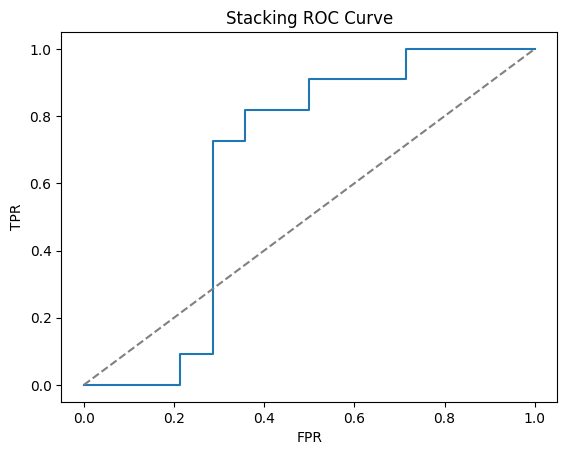

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
#Evaluate the best stacking model on test_df
model = grid_stack.best_estimator_
y_true       = test_df[TARGET]
y_pred       = model.predict(test_df[finalFEATURES])
y_proba      = model.predict_proba(test_df[finalFEATURES])[:,1]

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_proba))

#ROC curve plot:
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Stacking ROC Curve")
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.36      0.45        14
           1       0.47      0.73      0.57        11

    accuracy                           0.52        25
   macro avg       0.55      0.54      0.51        25
weighted avg       0.56      0.52      0.51        25

Confusion Matrix:
 [[5 9]
 [3 8]]
ROC-AUC: 0.5194805194805194


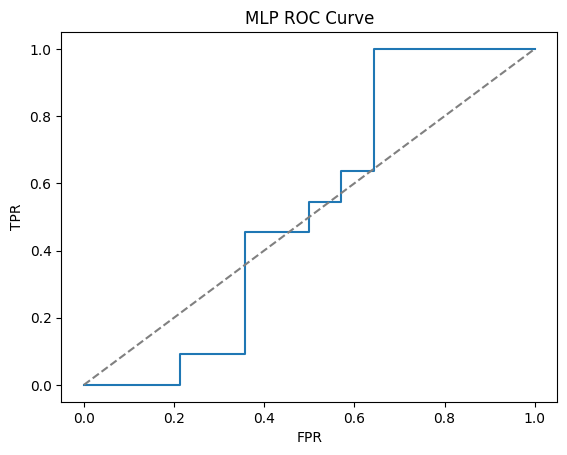

In [40]:
#Evaluate the LR model on test_df
model = gs_lr.best_estimator_
y_true       = test_df[TARGET]
y_pred       = model.predict(test_df[finalFEATURES])
y_proba      = model.predict_proba(test_df[finalFEATURES])[:,1]

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_proba))

#ROC curve plot:
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Logistic Regression ROC Curve")
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.29      0.36        14
           1       0.41      0.64      0.50        11

    accuracy                           0.44        25
   macro avg       0.46      0.46      0.43        25
weighted avg       0.46      0.44      0.42        25

Confusion Matrix:
 [[ 4 10]
 [ 4  7]]
ROC-AUC: 0.512987012987013


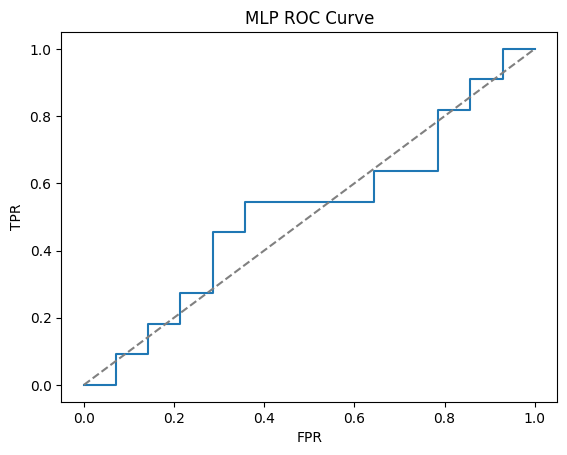

In [39]:
#Evaluate the MLP model on test_df
model = gs_mlp.best_estimator_
y_true       = test_df[TARGET]
y_pred       = model.predict(test_df[finalFEATURES])
y_proba      = model.predict_proba(test_df[finalFEATURES])[:,1]

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_proba))

#ROC curve plot:
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("MLP ROC Curve")
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        14
           1       0.42      0.45      0.43        11

    accuracy                           0.48        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.48      0.48      0.48        25

Confusion Matrix:
 [[7 7]
 [6 5]]
ROC-AUC: 0.5454545454545454


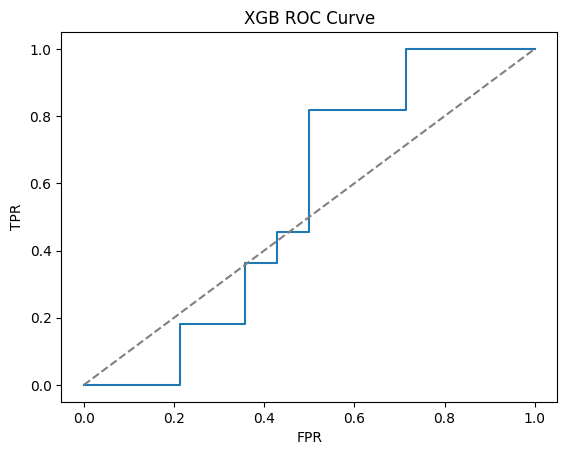

In [41]:
#Evaluate the XGB model on test_df
model = rs_xgb.best_estimator_
y_true       = test_df[TARGET]
y_pred       = model.predict(test_df[finalFEATURES])
y_proba      = model.predict_proba(test_df[finalFEATURES])[:,1]

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_proba))

#ROC curve plot:
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("XGB ROC Curve")
plt.show()
